## ALFA Primary and First Side Lobe Stokes I Beam Model

Based on [GALFA Technical Memo 2004-01](http://www.astro.cornell.edu/~haynes/pre204/docs/heiles_beams.pdf)

This is a notebook which implements the parameterized ALFA beam model from Carl Heiles' 2004 memo from the GALFA survey.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Parameterized Primary Lobe Model

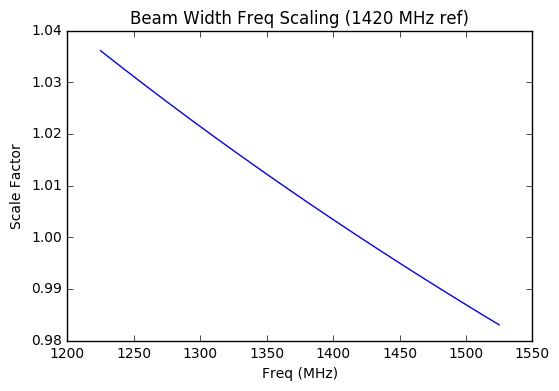

In [2]:
# Beam width frequency dependence
freqsMHz = np.linspace(1225, 1525, 1024)
scaleFactor = (freqsMHz / 1420.)**(-0.24)
plt.plot(freqsMHz, scaleFactor)
plt.xlabel('Freq (MHz)')
plt.ylabel('Scale Factor')
plt.title('Beam Width Freq Scaling (1420 MHz ref)')

In [3]:
# Parameterized Stokes I primary lobe

# Table 1 Primary Lobe Parameters
hpbwArcMin = 3.35 # Half-Power Beam Width in arcmin
hpbwDeltaF = -0.18 # Derivative of the HPWB as a function of frequency d(hpbwArcMin) / d(100 MHz)
ellipArcMin = 0.22 # Beam ellipticity in arcmin
ellipPA = np.pi/2 # Position angle of the ellipse, in radians
comaAmp = 0. # amplitude of the coma abberation
comaPA = 0. # Position angle of the coma abberation, in radians

# derived parameters
beamWidth = (hpbwArcMin / 1.665) * (1/60.) * (np.pi/180.)
ellip = ellipArcMin / hpbwArcMin
Theta0 = (2. * beamWidth / (np.sqrt(1. - ellip**2.) + 1.))
Theta1 = (2. * beamWidth - Theta0)

def normPrimaryLobe(phi, theta, freq=1420.):
    """phi: azimuth angle, in radians
    theta: altitude angle, in arcmin
    freq: float, obersving frequency in MHz"""
    thetaScaled = theta / (freq / 1420.)**(-0.24)
    thetaRad = thetaScaled * (1/60.) * (np.pi/180.)
    return np.exp( -1. * thetaRad**2. * (1. - (comaAmp * comaPA / Theta0)) / \
                  (Theta0 * Theta1 / np.sqrt( (Theta0 * np.cos(phi - ellipPA))**2. + (Theta1 * np.sin(phi - ellipPA))**2. ))**2.)
    #return np.exp( -1. * thetaRad**2. * (1. - (comaAmp * comaPA / Theta0)) / (Theta0 + Theta1 * np.cos(2. * (phi - ellipPA)))**2.)

In [4]:
# Generate the primary beam image

xSize = 256
ySize = 256
xWidth = 20. # arcmin
yWidth = 20. # arcmin
obsFreq = 1420. # MHz

xRange = np.linspace(-1.*xWidth/2., xWidth/2., xSize)
yRange = np.linspace(-1.*yWidth/2., yWidth/2., ySize)
xx, yy = np.meshgrid(xRange, yRange)

rr = np.sqrt(xx**2. + yy**2.)
phis = np.arctan2(yy, xx)

primaryLobeResp = np.zeros((xSize, ySize))

for ii in np.arange(xSize):
    for jj in np.arange(ySize):
        primaryLobeResp[ii, jj] = normPrimaryLobe(phis[ii, jj], rr[ii, jj], freq=obsFreq)

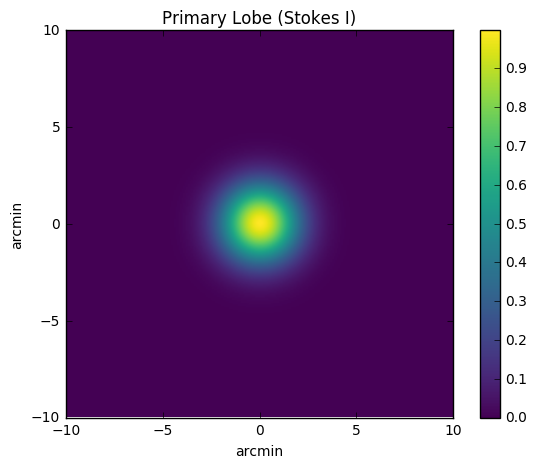

In [5]:
# Plot a primary beam image

fig = plt.figure(figsize=(7, 5)) # width, height
plt.imshow(np.abs(primaryLobeResp), cmap=plt.get_cmap('viridis'),\
           extent=(-1.*xWidth/2., xWidth/2., -1.*yWidth/2., yWidth/2.))
plt.colorbar()
plt.title('Primary Lobe (Stokes I)')
plt.ylabel('arcmin')
plt.xlabel('arcmin')

### Parameterized First Sidelobe Model

In [6]:
# read in Fourier coefficients file
fourierCoeffFile = 'ALFAfourier.dat'

hgtArr = np.zeros((7, 8), dtype='complex')
cenArr = np.zeros((7, 8), dtype='complex')
widArr = np.zeros((7, 8), dtype='complex')

with open (fourierCoeffFile, 'r') as fh:
    data = fh.read()
lines = data.split('\n')

for fid in np.arange(7):
    hgtArr[fid] = np.array(map(float,lines[3 + fid*7].split(' ')[2:])) + 1j * np.array(map(float,lines[4 + fid*7].split(' ')[2:]))
    cenArr[fid] = np.array(map(float,lines[5 + fid*7].split(' ')[2:])) + 1j * np.array(map(float,lines[6 + fid*7].split(' ')[2:]))
    widArr[fid] = np.array(map(float,lines[7 + fid*7].split(' ')[2:])) + 1j * np.array(map(float,lines[8 + fid*7].split(' ')[2:]))

In [7]:
# Functions to generate the sidelobe using fitted Fourier coefficients

def hgtCoeff(phi, feed):
    """eq 5a
    phi: angle in radian
    feed: ALFA feed ID"""
    idx = np.roll(np.arange(-4, 4), 4)
    return np.sum(hgtArr[feed] * np.exp(2. * np.pi * 1j * idx * (phi / (2. * np.pi))))

def cenCoeff(phi, feed):
    """eq 5a
    phi: angle in radian
    feed: ALFA feed ID"""
    idx = np.roll(np.arange(-4, 4), 4)
    return np.sum(cenArr[feed] * np.exp(2. * np.pi * 1j * idx * (phi / (2. * np.pi))))

def widCoeff(phi, feed):
    """eq 5a
    phi: angle in radian
    feed: ALFA feed ID"""
    idx = np.roll(np.arange(-4, 4), 4)
    return np.sum(widArr[feed] * np.exp(2. * np.pi * 1j * idx * (phi / (2. * np.pi))))

def firstSideLobeResponse(phi, r, feed, freq=1420.):
    """eq 5b
    Note: eq 5b does not include the -1 in the exponent, this is corrected here
    phi: angle in radian
    r: distance from beam centre in arcmin
    freq: float, obersving frequency in MHz"""
    rScaled = r / ((freq / 1420.)**(-0.24)) # eq 4a
    return hgtCoeff(phi, feed) * np.exp( -1. * ((rScaled - cenCoeff(phi, feed))**2.) / ((0.6005612 * widCoeff(phi, feed))**2.))

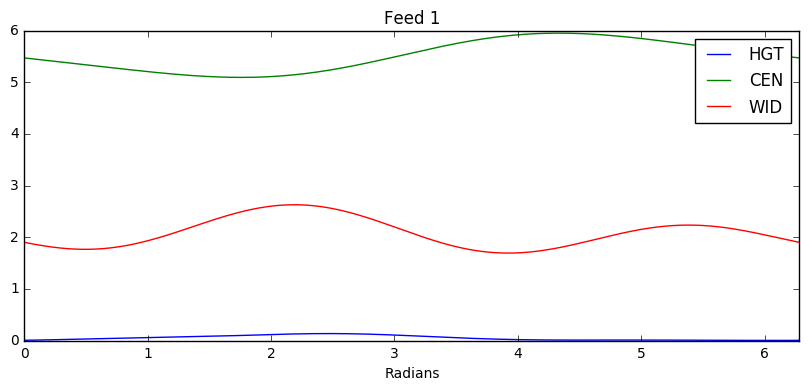

In [8]:
# 1-d functions
feedID = 1

phis = np.linspace(0, 2. * np.pi, 1024)
hgtResp = np.zeros(1024, dtype='complex')
cenResp = np.zeros(1024, dtype='complex')
widResp = np.zeros(1024, dtype='complex')
for ii in np.arange(1024):
    hgtResp[ii] = hgtCoeff(phis[ii], feedID)
    cenResp[ii] = cenCoeff(phis[ii], feedID)
    widResp[ii] = widCoeff(phis[ii], feedID)

fig = plt.figure(figsize=(10, 4)) # width, height
plt.plot(phis, np.abs(hgtResp), label='HGT')
plt.plot(phis, np.abs(cenResp), label='CEN')
plt.plot(phis, np.abs(widResp), label='WID')
plt.xlim(0, 2.*np.pi)
plt.xlabel('Radians')
plt.title('Feed %i'%feedID)
plt.legend()

In [9]:
# Generate the first side lobe

feedID = 6

xSize = 256
ySize = 256
xWidth = 20. # arcmin
yWidth = 20. # arcmin

xRange = np.linspace(-1.*xWidth/2., xWidth/2., xSize)
yRange = np.linspace(-1.*yWidth/2., yWidth/2., ySize)
xx, yy = np.meshgrid(xRange, yRange)

rr = np.sqrt(xx**2. + yy**2.)
phis = np.arctan2(yy, xx)

sideLobeResp = np.zeros((xSize, ySize), dtype='complex')

for ii in np.arange(xSize):
    for jj in np.arange(ySize):
        sideLobeResp[ii, jj] = firstSideLobeResponse(phis[ii, jj], rr[ii, jj], feedID)

sideLobeStokesI = np.abs(sideLobeResp)

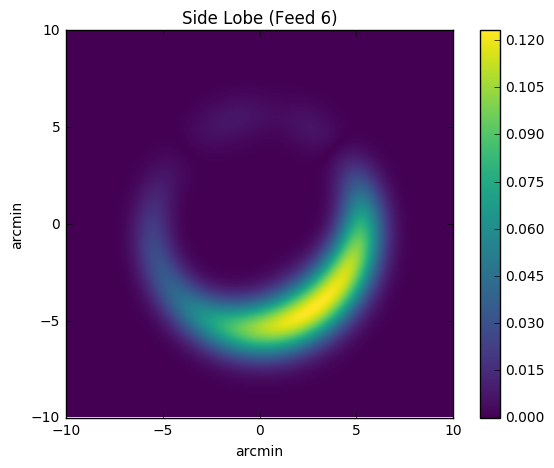

In [10]:
# Plot the first side lobe

fig = plt.figure(figsize=(7, 5)) # width, height
plt.imshow(np.abs(sideLobeStokesI), cmap=plt.get_cmap('viridis'),\
           extent=(-1.*xWidth/2., xWidth/2., -1.*yWidth/2., yWidth/2.))
plt.colorbar()
plt.title('Side Lobe (Feed %i)'%feedID)
plt.ylabel('arcmin')
plt.xlabel('arcmin')

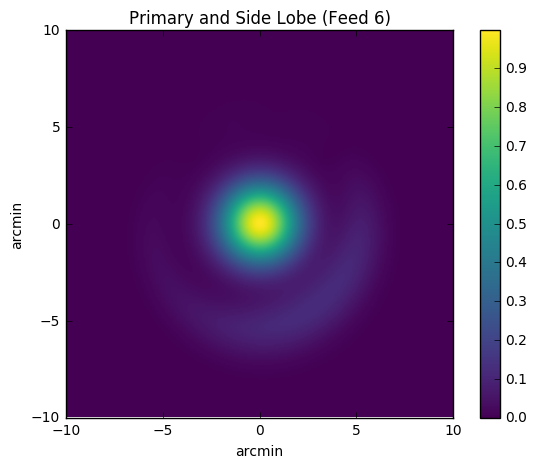

In [11]:
# Plot the primary lobe and first side lobe

fig = plt.figure(figsize=(7, 5)) # width, height
plt.imshow(primaryLobeResp + sideLobeStokesI, cmap=plt.get_cmap('viridis'),\
           extent=(-1.*xWidth/2., xWidth/2., -1.*yWidth/2., yWidth/2.))
plt.colorbar()
plt.title('Primary and Side Lobe (Feed %i)'%feedID)
plt.ylabel('arcmin')
plt.xlabel('arcmin')

### All ALFA Beams

In [12]:
# Generate an image of the full ALFA system

# Table 2: beam position offsets
xxBeamOff = np.array([0., 164.5, 329.1, 164.5, -164.5, -329.1, -164.5]) / 60. # arcmin
yyBeamOff = np.array([0., -332.6, 0., 332.6, 332.6, 0., -332.6]) / 60. # arcmin

obsFreq = 1225. # MHz

xSize = 256
ySize = 256
xWidth = 30. # arcmin
yWidth = 30. # arcmin

xRange = np.linspace(-1.*xWidth/2., xWidth/2., xSize)
yRange = np.linspace(-1.*yWidth/2., yWidth/2., ySize)

beamResp = np.zeros((xSize, ySize), dtype='float')

for fid in np.arange(7):
    xx, yy = np.meshgrid(xRange + xxBeamOff[fid], yRange + yyBeamOff[fid])

    rr = np.sqrt(xx**2. + yy**2.)
    phis = np.arctan2(yy, xx)

    for ii in np.arange(xSize):
        for jj in np.arange(ySize):
            beamResp[ii, jj] += normPrimaryLobe(phis[ii, jj], rr[ii, jj])
            beamResp[ii, jj] += np.abs(firstSideLobeResponse(phis[ii, jj], rr[ii, jj], fid, freq=obsFreq))

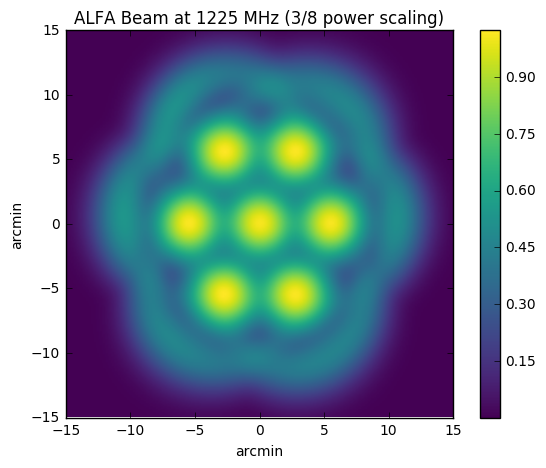

In [13]:
# Plot the ALFA receiver using 3/8 power scaling, same as Fig 12 of the memo

fig = plt.figure(figsize=(7, 5)) # width, height
plt.imshow(beamResp**(3./8.), cmap=plt.get_cmap('viridis'),\
           extent=(-1.*xWidth/2., xWidth/2., -1.*yWidth/2., yWidth/2.))
plt.colorbar()
plt.title('ALFA Beam at %i MHz (3/8 power scaling)'%int(obsFreq))
plt.ylabel('arcmin')
plt.xlabel('arcmin')

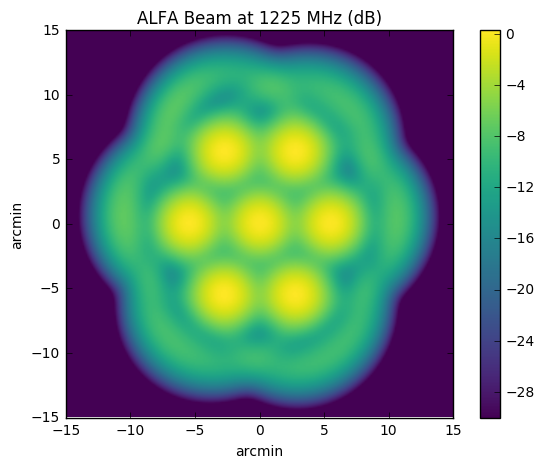

In [14]:
# Plot the ALFA receiver in dBs

dBbeamResp = 10. * np.log10(beamResp)
dBbeamResp = np.clip(dBbeamResp, a_min=-30., a_max=np.max(dBbeamResp))

fig = plt.figure(figsize=(7, 5)) # width, height
plt.imshow(dBbeamResp, cmap=plt.get_cmap('viridis'), extent=(-1.*xWidth/2., xWidth/2., -1.*yWidth/2., yWidth/2.))
plt.colorbar()
plt.title('ALFA Beam at %i MHz (dB)'%int(obsFreq))
plt.ylabel('arcmin')
plt.xlabel('arcmin')

### FRB Detection Sensitivity - Beam Size Relation

For the ALFABURST survey, given an FRB brightness, we can compute the sky coverage based. For a brighter FRB detection threshold the sky coverage will be larger, as the sidelobes can be included.

If we believe that the sidelobes out to -30 dB of the peak gain are sensitive to FRB detection then we can compute the amount of sky illuminated by the beam:

In [15]:
dBthresh = -30. # dB
nPix = len(dBbeamResp[np.where(dBbeamResp > dBthresh)]) # number of pixels which have a gain greater than the dB threshold
totalPix = float(xSize * ySize)
totalCoverage = (xWidth / 60.) * (yWidth / 60.) # sky coverage of image in deg^2
beamCoverage = (nPix / totalPix) * totalCoverage

print 'Sky illumination (beam > %.0f dB): %f deg^2'%(dBthresh, beamCoverage)

Sky illumination (beam > -30 dB): 0.172955 deg^2


For a total mean survey time of 322 hours this results in a survey metric of:

In [16]:
meanObsHrs = 322.
print '%.1f deg^2 hrs'%(beamCoverage * meanObsHrs)

55.7 deg^2 hrs


The survey metric as a function of the beam sensitivity can be plotted as:

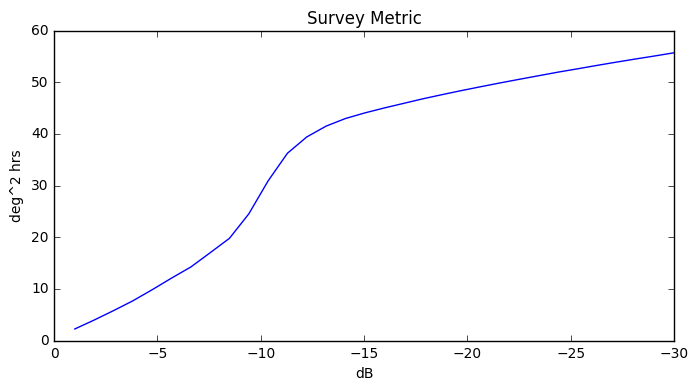

In [17]:
steps = 32
sensLevel = np.linspace(-1, -30, steps)
surveyMetric = np.zeros(steps)
for sid,sl in enumerate(sensLevel):
    nPix = len(dBbeamResp[np.where(dBbeamResp > sl)])
    surveyMetric[sid] = (nPix / totalPix) * totalCoverage * meanObsHrs

fig = plt.figure(figsize=(8, 4)) # width, height
plt.plot(sensLevel, surveyMetric)
plt.gca().invert_xaxis()
plt.xlabel('dB')
plt.ylabel('deg^2 hrs')
plt.title('Survey Metric')

Up to approximately -8 dB only the primary lobe is considered in the sky coverage, the sharp increase up to approximately -12 dB is the introduction of the first side lobe coverage. The remaining coverage out to -30 dB is the remaining sensitivity of the first side lobe. If the second side lobe was modelled there would again be a sharp increase in sensitivity out around -20 dB, but not as prominent as the first side lobe.

We need to relate the beam response to a sky sensitivity using the radiometer equation.

$$
S_{min} = \textrm{SEFD} \frac{\textrm{SNR}_{min}}{\sqrt{D \; \Delta \tau \; \Delta \nu}}
$$

where the SEFD includes a efficiency factor which accounts for the beam gain. There is a bit of an ambiguity as to whether the SEFD accounts for the sensitivity out to the HWFP point at the 3 dB point, or if it is for the absolute beam centre. For our case we will be conservative and say that the SEFD relates to the absolute centre, this is a difference in 3 dB.

The survey metric for 4 ms pulses based on the minimum detection threshold is:

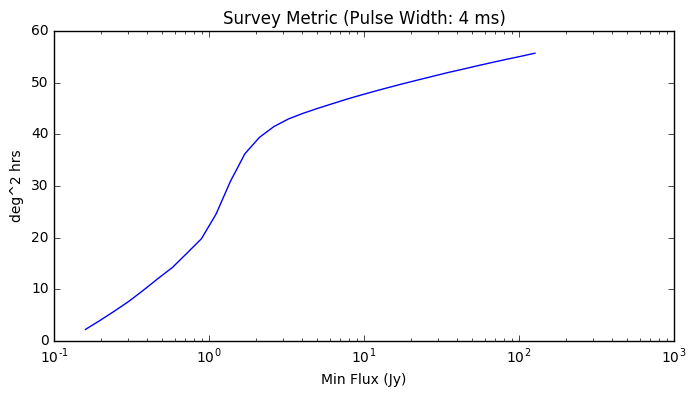

In [18]:
# Parameters
SEFD = 3. # Jy, SEFD of ALFA (main beam)
threshold = 10. # SNR threshold of detection pipeline
pulseWidth = 4. * 1000. # us, expected pulse width
tRes = 256. # us, ALFABURST spectra time resolution
dFactor = pulseWidth / tRes# decimation factor
bw = 56. * 1e6 # ALFABURST effective bandwidth in Hz
beamEffic = 10.**((np.linspace(-1, -30, steps) - 3.) / 10.)

sMin = (1./beamEffic) * SEFD * (threshold / np.sqrt(dFactor * (tRes * 1e-6) * bw)) # Minimum flux density detection, based on radiometer equation

fig = plt.figure(figsize=(8, 4)) # width, height
plt.semilogx(sMin, surveyMetric)
plt.xlabel('Min Flux (Jy)')
plt.ylabel('deg^2 hrs')
plt.title('Survey Metric (Pulse Width: 4 ms)')